# Hoja de Trabajo 2

- Josue Marroquin 22397
- Sebastian Huertas 22295

In [12]:
# Libs
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import copy
import torch.nn.init as init


## Ejercicio 1 - Experimentación Práctica

### Task 1 - Preparación del conjunto de datos
Cargue el conjunto de datos de Iris utilizando bibliotecas como sklearn.datasets. Luego, divida el conjunto de datos
en conjuntos de entrenamiento y validación.

In [5]:
# Cargar el conjunto de datos de Iris
iris = load_iris()
X = iris.data  # Características: sepal length, sepal width, petal length, petal width
y = iris.target  # Etiquetas: 0=setosa, 1=versicolor, 2=virginica

# Crear DataFrame para mejor visualización
feature_names = iris.feature_names
target_names = iris.target_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['species'] = df['target'].map({0: target_names[0], 1: target_names[1], 2: target_names[2]})

print("Información del conjunto de datos:")
print(f"Forma del dataset: {X.shape}")
print(f"Número de características: {X.shape[1]}")
print(f"Número de muestras: {X.shape[0]}")
print(f"Clases: {target_names}")
print(f"Distribución de clases: {np.bincount(y)}")

# Mostrar las primeras filas
print("\nPrimeras 5 filas del dataset:")
print(df.head())

# Dividir el conjunto de datos en entrenamiento y validación (80% - 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Mantener la proporción de clases en ambos conjuntos
)

print(f"\nConjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de validación: {X_val.shape[0]} muestras")
print(f"Distribución en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución en validación: {np.bincount(y_val)}")

# Estandarizar las características (opcional pero recomendado para muchos algoritmos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\nDatos preparados exitosamente para entrenamiento y validación")
print("Variables disponibles:")
print("- X_train, X_val: características originales")
print("- X_train_scaled, X_val_scaled: características estandarizadas")
print("- y_train, y_val: etiquetas")
print("- df: DataFrame completo con información descriptiva")

Información del conjunto de datos:
Forma del dataset: (150, 4)
Número de características: 4
Número de muestras: 150
Clases: ['setosa' 'versicolor' 'virginica']
Distribución de clases: [50 50 50]

Primeras 5 filas del dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target species  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa  

Conjunto de entrenamiento: 120 muestras
Conjunto de validación: 30 muestras
Distribución en entrenamiento: [40 40 40]
Distribución en validación: [10 10 10]

Datos preparados exi

### Task 2 - Arquitectura modelo
Cree una red neuronal feedforward simple utilizando nn.Module de PyTorch. Luego, defina capa de entrada, capas
ocultas y capa de salida. Después, elija las funciones de activación y el número de neuronas por capa

In [8]:
# Task 2 - Arquitectura del modelo

# Configurar dispositivo (GPU si está disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

# Definir la arquitectura de la red neuronal feedforward
class IrisClassifier(nn.Module):
    def __init__(self, input_size=4, hidden_size1=16, hidden_size2=8, num_classes=3):
        super(IrisClassifier, self).__init__()
        
        # Definir las capas
        self.fc1 = nn.Linear(input_size, hidden_size1)      # Capa de entrada: 4 -> 16
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)    # Primera capa oculta: 16 -> 8
        self.fc3 = nn.Linear(hidden_size2, num_classes)     # Capa de salida: 8 -> 3
        
        # Capa de dropout para regularización
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Forward pass a través de la red
        x = F.relu(self.fc1(x))         # Activación ReLU en primera capa
        x = self.dropout(x)             # Aplicar dropout
        x = F.relu(self.fc2(x))         # Activación ReLU en segunda capa
        x = self.dropout(x)             # Aplicar dropout
        x = self.fc3(x)                 # Capa de salida (sin activación, se aplica en loss)
        return x

# Crear instancia del modelo
model = IrisClassifier(input_size=4, hidden_size1=16, hidden_size2=8, num_classes=3)
model = model.to(device)

# Mostrar la arquitectura del modelo
print("Arquitectura del modelo:")
print(model)
print(f"\nNúmero total de parámetros: {sum(p.numel() for p in model.parameters())}")
print(f"Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Convertir datos de numpy a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)

print(f"\nForma de los tensores:")
print(f"X_train: {X_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"y_val: {y_val_tensor.shape}")

# Crear DataLoaders para entrenamiento por lotes
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders creados:")
print(f"Tamaño del lote: {batch_size}")
print(f"Número de lotes de entrenamiento: {len(train_loader)}")
print(f"Número de lotes de validación: {len(val_loader)}")

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()  # Para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print(f"\nConfiguración de entrenamiento:")
print(f"Función de pérdida: {criterion}")
print(f"Optimizador: {optimizer}")
print(f"Tasa de aprendizaje: 0.001")

# Función para probar el modelo con datos de ejemplo
def test_forward_pass():
    model.eval()
    with torch.no_grad():
        # Tomar una muestra pequeña para probar
        sample_input = X_train_tensor[:3]  # 3 muestras
        output = model(sample_input)
        probabilities = F.softmax(output, dim=1)
        predictions = torch.argmax(output, dim=1)
        
        print(f"\nPrueba del forward pass:")
        print(f"Input shape: {sample_input.shape}")
        print(f"Output shape: {output.shape}")
        print(f"Predictions: {predictions.cpu().numpy()}")
        print(f"Probabilities:\n{probabilities.cpu().numpy()}")

test_forward_pass()
print("\nModelo creado y configurado")

Dispositivo utilizado: cpu
Arquitectura del modelo:
IrisClassifier(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Número total de parámetros: 243
Parámetros entrenables: 243

Forma de los tensores:
X_train: torch.Size([120, 4])
X_val: torch.Size([30, 4])
y_train: torch.Size([120])
y_val: torch.Size([30])

DataLoaders creados:
Tamaño del lote: 16
Número de lotes de entrenamiento: 8
Número de lotes de validación: 2

Configuración de entrenamiento:
Función de pérdida: CrossEntropyLoss()
Optimizador: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Tasa de aprendizaje: 0.001

Prueba del forward pass:
Input sha

### Task 3 - Funciones de Pérdida
Utilice diferentes funciones de pérdida comunes como Cross-Entropy Loss y MSE para clasificación. Entrene el
modelo con diferentes funciones de pérdida y registre las pérdidas de entrenamiento y test. Debe utilizar al menos 3
diferentes funciones. Es decir, procure que su código sea capaz de parametrizar el uso de diferentes funciones de
pérdida.

In [10]:
# Task 3 - Funciones de Pérdida

# Función para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    """
    Entrena el modelo con una función de pérdida específica
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Modo entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Estadísticas
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Modo evaluación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        # Calcular promedios
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Imprimir progreso cada 20 épocas
        if (epoch + 1) % 20 == 0:
            print(f'Época [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Función para crear diferentes modelos y funciones de pérdida
def create_model():
    """Crea una nueva instancia del modelo"""
    return IrisClassifier(input_size=4, hidden_size1=16, hidden_size2=8, num_classes=3).to(device)

# Función para convertir etiquetas a one-hot para MSE
def to_one_hot(labels, num_classes=3):
    """Convierte etiquetas a formato one-hot para MSE"""
    one_hot = torch.zeros(labels.size(0), num_classes)
    one_hot.scatter_(1, labels.cpu().unsqueeze(1), 1)
    return one_hot.to(device)

# Función de pérdida personalizada MSE para clasificación
def mse_classification_loss(outputs, targets):
    """MSE adaptado para clasificación multiclase"""
    # Aplicar softmax a las salidas
    probabilities = F.softmax(outputs, dim=1)
    # Convertir targets a one-hot
    targets_one_hot = to_one_hot(targets, num_classes=3)
    # Calcular MSE
    return F.mse_loss(probabilities, targets_one_hot)

# Configurar las diferentes funciones de pérdida
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'MSE (adaptado)': mse_classification_loss,
    'NLLLoss': nn.NLLLoss(),  # Requiere log_softmax en el modelo
}

# Modificar el modelo para NLLLoss
class IrisClassifierNLL(nn.Module):
    def __init__(self, input_size=4, hidden_size1=16, hidden_size2=8, num_classes=3):
        super(IrisClassifierNLL, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)  # log_softmax para NLLLoss

# Diccionario para almacenar resultados
results = {}

print("Iniciando entrenamiento con diferentes funciones de pérdida...")
print("=" * 60)

# Entrenar con cada función de pérdida
for loss_name, loss_fn in loss_functions.items():
    print(f"\n Entrenando con {loss_name}")
    print("-" * 40)
    
    # Crear modelo apropiado
    if loss_name == 'NLLLoss':
        current_model = IrisClassifierNLL().to(device)
    else:
        current_model = create_model()
    
    # Crear optimizador
    current_optimizer = optim.Adam(current_model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Entrenar modelo
    train_losses, val_losses, train_accs, val_accs = train_model(
        current_model, train_loader, val_loader, loss_fn, current_optimizer, num_epochs=100
    )
    
    # Guardar resultados
    results[loss_name] = {
        'model': current_model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accs,
        'val_accuracies': val_accs,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1]
    }
    
    print(f" Precisión final - Train: {train_accs[-1]:.2f}%, Val: {val_accs[-1]:.2f}%")

print("\n" + "=" * 60)
print("Entrenamiento completado para todas las funciones de pérdida")

# Comparar resultados finales
print("\n RESUMEN DE RESULTADOS:")
print("-" * 50)
for loss_name, result in results.items():
    print(f"{loss_name:20s} | Train: {result['final_train_acc']:6.2f}% | Val: {result['final_val_acc']:6.2f}%")

Iniciando entrenamiento con diferentes funciones de pérdida...

 Entrenando con CrossEntropyLoss
----------------------------------------
Época [20/100], Train Loss: 0.6326, Train Acc: 65.83%, Val Loss: 0.6423, Val Acc: 66.67%
Época [40/100], Train Loss: 0.4272, Train Acc: 82.50%, Val Loss: 0.4187, Val Acc: 80.00%
Época [20/100], Train Loss: 0.6326, Train Acc: 65.83%, Val Loss: 0.6423, Val Acc: 66.67%
Época [40/100], Train Loss: 0.4272, Train Acc: 82.50%, Val Loss: 0.4187, Val Acc: 80.00%
Época [60/100], Train Loss: 0.3381, Train Acc: 86.67%, Val Loss: 0.3057, Val Acc: 86.67%
Época [80/100], Train Loss: 0.2666, Train Acc: 88.33%, Val Loss: 0.2207, Val Acc: 90.00%
Época [60/100], Train Loss: 0.3381, Train Acc: 86.67%, Val Loss: 0.3057, Val Acc: 86.67%
Época [80/100], Train Loss: 0.2666, Train Acc: 88.33%, Val Loss: 0.2207, Val Acc: 90.00%
Época [100/100], Train Loss: 0.2122, Train Acc: 92.50%, Val Loss: 0.1669, Val Acc: 96.67%
 Precisión final - Train: 92.50%, Val: 96.67%

 Entrenando c

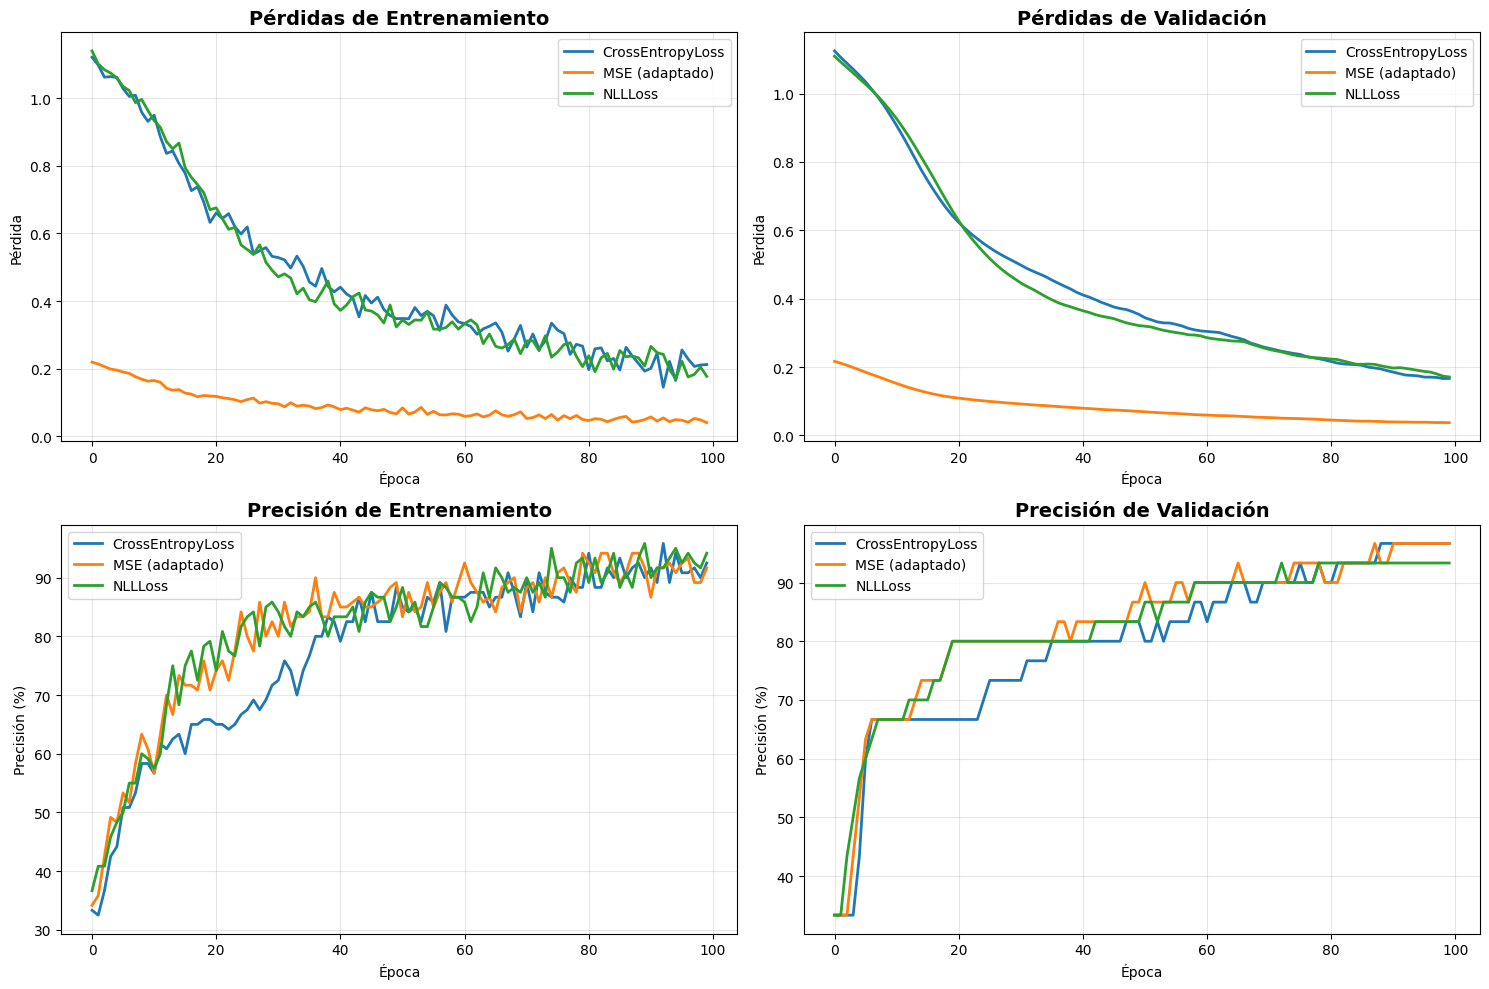

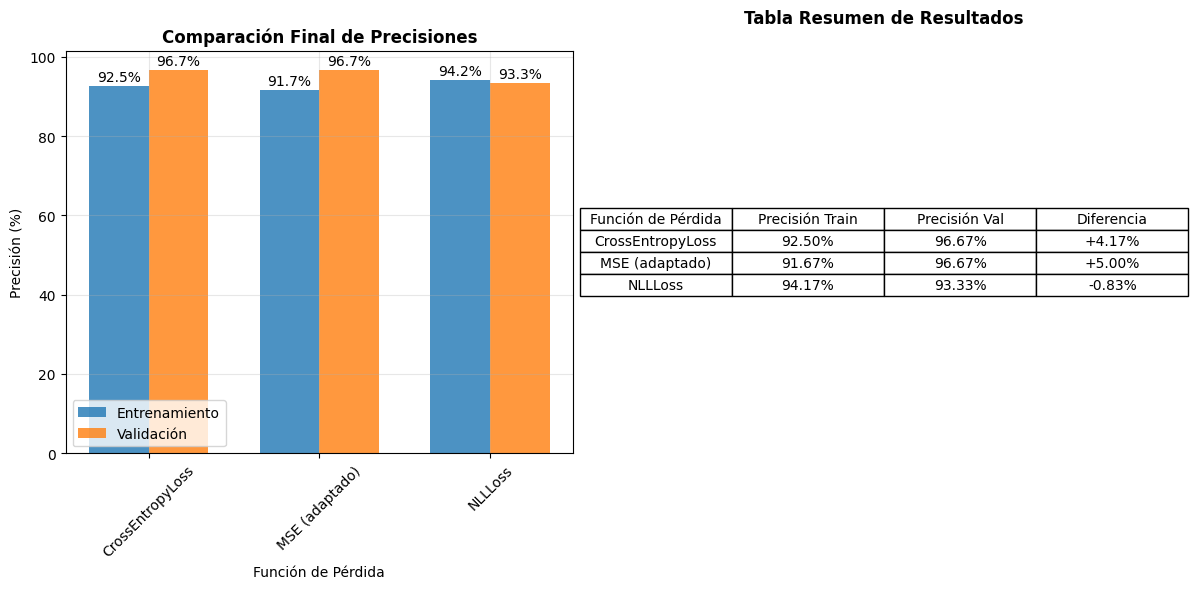


 ANÁLISIS DETALLADO DE RESULTADOS

MEJOR FUNCIÓN DE PÉRDIDA: CrossEntropyLoss
 Precisión de validación: 96.67%

 CONVERGENCIA:
   CrossEntropyLoss    :  67 épocas para alcanzar 90% en entrenamiento
   MSE (adaptado)      :  36 épocas para alcanzar 90% en entrenamiento
   NLLLoss             :  63 épocas para alcanzar 90% en entrenamiento

 OVERFITTING (Train - Val):
   CrossEntropyLoss    : -4.17% ( Bueno)
   MSE (adaptado)      : -5.00% ( Bueno)
   NLLLoss             : +0.83% ( Bueno)


In [11]:
plt.figure(figsize=(15, 10))

# Subplot 1: Pérdidas de entrenamiento
plt.subplot(2, 2, 1)
for loss_name, result in results.items():
    plt.plot(result['train_losses'], label=f'{loss_name}', linewidth=2)
plt.title('Pérdidas de Entrenamiento', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Pérdidas de validación
plt.subplot(2, 2, 2)
for loss_name, result in results.items():
    plt.plot(result['val_losses'], label=f'{loss_name}', linewidth=2)
plt.title('Pérdidas de Validación', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Precisión de entrenamiento
plt.subplot(2, 2, 3)
for loss_name, result in results.items():
    plt.plot(result['train_accuracies'], label=f'{loss_name}', linewidth=2)
plt.title('Precisión de Entrenamiento', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Precisión de validación
plt.subplot(2, 2, 4)
for loss_name, result in results.items():
    plt.plot(result['val_accuracies'], label=f'{loss_name}', linewidth=2)
plt.title('Precisión de Validación', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Crear gráfico de barras para comparación final
plt.figure(figsize=(12, 6))

loss_names = list(results.keys())
train_accs = [results[name]['final_train_acc'] for name in loss_names]
val_accs = [results[name]['final_val_acc'] for name in loss_names]

x = range(len(loss_names))
width = 0.35

plt.subplot(1, 2, 1)
bars1 = plt.bar([i - width/2 for i in x], train_accs, width, label='Entrenamiento', alpha=0.8)
bars2 = plt.bar([i + width/2 for i in x], val_accs, width, label='Validación', alpha=0.8)

plt.xlabel('Función de Pérdida')
plt.ylabel('Precisión (%)')
plt.title('Comparación Final de Precisiones', fontweight='bold')
plt.xticks(x, loss_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')

# Tabla resumen
plt.subplot(1, 2, 2)
plt.axis('tight')
plt.axis('off')

table_data = []
for loss_name, result in results.items():
    table_data.append([
        loss_name,
        f"{result['final_train_acc']:.2f}%",
        f"{result['final_val_acc']:.2f}%",
        f"{result['final_val_acc'] - result['final_train_acc']:+.2f}%"
    ])

table = plt.table(cellText=table_data,
                  colLabels=['Función de Pérdida', 'Precisión Train', 'Precisión Val', 'Diferencia'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.title('Tabla Resumen de Resultados', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Análisis detallado
print("\n" + "="*60)
print(" ANÁLISIS DETALLADO DE RESULTADOS")
print("="*60)

best_val_acc = max(results[name]['final_val_acc'] for name in results.keys())
best_loss_fn = [name for name, result in results.items() if result['final_val_acc'] == best_val_acc][0]

print(f"\nMEJOR FUNCIÓN DE PÉRDIDA: {best_loss_fn}")
print(f" Precisión de validación: {best_val_acc:.2f}%")

print(f"\n CONVERGENCIA:")
for loss_name, result in results.items():
    epochs_to_90 = next((i for i, acc in enumerate(result['train_accuracies']) if acc >= 90), len(result['train_accuracies']))
    print(f"   {loss_name:20s}: {epochs_to_90:3d} épocas para alcanzar 90% en entrenamiento")

print(f"\n OVERFITTING (Train - Val):")
for loss_name, result in results.items():
    diff = result['final_train_acc'] - result['final_val_acc']
    status = " Bueno" if diff < 5 else "  Moderado" if diff < 10 else "❌ Alto"
    print(f"   {loss_name:20s}: {diff:+.2f}% ({status})")

### Task 4 - Técnicas de Regularización
Utilice distintas técnicas de regularización como L1, L2 y dropout. Entrene el modelo con y sin técnicas de
regularización y observe el impacto en el overfitting y la generalización. Debe utilizar al menos 3 diferentes técnicas.
Es decir, procure que su código sea capaz de parametrizar el uso de diferentes técnicas de regularización.

In [13]:
# Task 4 - Técnicas de Regularización

# Reiniciar la semilla para experimentos reproducibles
torch.manual_seed(42)
np.random.seed(42)

# Modelos con diferentes técnicas de regularización
class IrisClassifierDropout(nn.Module):
    """Modelo con Dropout como regularización"""
    def __init__(self, input_size=4, hidden_size1=16, hidden_size2=8, num_classes=3, dropout_rate=0.5):
        super(IrisClassifierDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class IrisClassifierBatchNorm(nn.Module):
    """Modelo con Batch Normalization como regularización"""
    def __init__(self, input_size=4, hidden_size1=16, hidden_size2=8, num_classes=3):
        super(IrisClassifierBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

class IrisClassifierNoRegularization(nn.Module):
    """Modelo sin regularización (baseline)"""
    def __init__(self, input_size=4, hidden_size1=16, hidden_size2=8, num_classes=3):
        super(IrisClassifierNoRegularization, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Función de entrenamiento para regularización
def train_model_regularization(model, train_loader, val_loader, optimizer, num_epochs=150):
    """
    Entrena el modelo y retorna métricas de entrenamiento
    """
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        # Calcular métricas
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        if (epoch + 1) % 30 == 0:
            print(f'Época [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Configuraciones de regularización
regularization_configs = {
    'Sin Regularización': {
        'model_class': IrisClassifierNoRegularization,
        'optimizer_params': {'lr': 0.001, 'weight_decay': 0.0},
        'description': 'Modelo baseline sin técnicas de regularización'
    },
    'L2 Regularization': {
        'model_class': IrisClassifierNoRegularization,
        'optimizer_params': {'lr': 0.001, 'weight_decay': 0.01},
        'description': 'Regularización L2 (weight decay) en el optimizador'
    },
    'L1 Regularization': {
        'model_class': IrisClassifierNoRegularization,
        'optimizer_params': {'lr': 0.001, 'weight_decay': 0.0},
        'l1_lambda': 0.001,
        'description': 'Regularización L1 manual en la función de pérdida'
    },
    'Dropout (0.3)': {
        'model_class': IrisClassifierDropout,
        'model_params': {'dropout_rate': 0.3},
        'optimizer_params': {'lr': 0.001, 'weight_decay': 0.0},
        'description': 'Dropout con probabilidad 0.3'
    },
    'Dropout (0.5)': {
        'model_class': IrisClassifierDropout,
        'model_params': {'dropout_rate': 0.5},
        'optimizer_params': {'lr': 0.001, 'weight_decay': 0.0},
        'description': 'Dropout con probabilidad 0.5'
    },
    'Batch Normalization': {
        'model_class': IrisClassifierBatchNorm,
        'optimizer_params': {'lr': 0.001, 'weight_decay': 0.0},
        'description': 'Normalización por lotes entre capas'
    },
    'L2 + Dropout': {
        'model_class': IrisClassifierDropout,
        'model_params': {'dropout_rate': 0.3},
        'optimizer_params': {'lr': 0.001, 'weight_decay': 0.005},
        'description': 'Combinación de L2 y Dropout'
    }
}

# Función para aplicar regularización L1
def l1_regularization(model, l1_lambda):
    """Calcula la pérdida de regularización L1"""
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

# Función de entrenamiento con L1
def train_model_l1(model, train_loader, val_loader, optimizer, l1_lambda, num_epochs=150):
    """Entrenamiento con regularización L1 manual"""
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            ce_loss = criterion(outputs, batch_y)
            l1_loss = l1_regularization(model, l1_lambda)
            total_loss = ce_loss + l1_loss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validación (sin L1 para métricas limpias)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        # Calcular métricas
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        if (epoch + 1) % 30 == 0:
            print(f'Época [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Almacenar resultados de regularización
regularization_results = {}

print(" Iniciando experimentos de regularización...")
print("=" * 70)

# Entrenar con cada técnica de regularización
for reg_name, config in regularization_configs.items():
    print(f"\n  Entrenando con: {reg_name}")
    print(f" Descripción: {config['description']}")
    print("-" * 50)
    
    # Crear modelo
    model_params = config.get('model_params', {})
    current_model = config['model_class'](**model_params).to(device)
    
    # Crear optimizador
    optimizer_params = config['optimizer_params']
    current_optimizer = optim.Adam(current_model.parameters(), **optimizer_params)
    
    # Entrenar según el tipo de regularización
    if 'l1_lambda' in config:
        # Regularización L1 manual
        train_losses, val_losses, train_accs, val_accs = train_model_l1(
            current_model, train_loader, val_loader, current_optimizer, 
            config['l1_lambda'], num_epochs=150
        )
    else:
        # Regularización estándar
        train_losses, val_losses, train_accs, val_accs = train_model_regularization(
            current_model, train_loader, val_loader, current_optimizer, num_epochs=150
        )
    
    # Guardar resultados
    regularization_results[reg_name] = {
        'model': current_model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accs,
        'val_accuracies': val_accs,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1],
        'overfitting': train_accs[-1] - val_accs[-1],
        'config': config
    }
    
    print(f" Resultado final:")
    print(f"   Train: {train_accs[-1]:.2f}% | Val: {val_accs[-1]:.2f}% | Overfitting: {train_accs[-1] - val_accs[-1]:+.2f}%")

print("\n" + "=" * 70)
print(" Experimentos de regularización completados!")

# Resumen de resultados
print("\n RESUMEN DE TÉCNICAS DE REGULARIZACIÓN:")
print("-" * 70)
print(f"{'Técnica':<20} {'Train':<8} {'Val':<8} {'Overfitting':<12} {'Descripción'}")
print("-" * 70)

for reg_name, result in regularization_results.items():
    print(f"{reg_name:<20} {result['final_train_acc']:>6.2f}% {result['final_val_acc']:>6.2f}% "
          f"{result['overfitting']:>+8.2f}% {result['config']['description'][:30]}")

# Encontrar la mejor técnica para generalización
best_generalization = min(regularization_results.items(), key=lambda x: x[1]['overfitting'])
best_accuracy = max(regularization_results.items(), key=lambda x: x[1]['final_val_acc'])

print(f"\n MEJORES RESULTADOS:")
print(f"   Mejor generalización: {best_generalization[0]} (overfitting: {best_generalization[1]['overfitting']:+.2f}%)")
print(f"   Mejor precisión val:  {best_accuracy[0]} (precisión: {best_accuracy[1]['final_val_acc']:.2f}%)")

 Iniciando experimentos de regularización...

  Entrenando con: Sin Regularización
 Descripción: Modelo baseline sin técnicas de regularización
--------------------------------------------------
Época [30/150], Train Loss: 0.3048, Train Acc: 90.83%, Val Loss: 0.3526, Val Acc: 80.00%
Época [30/150], Train Loss: 0.3048, Train Acc: 90.83%, Val Loss: 0.3526, Val Acc: 80.00%
Época [60/150], Train Loss: 0.1230, Train Acc: 95.83%, Val Loss: 0.1775, Val Acc: 93.33%
Época [60/150], Train Loss: 0.1230, Train Acc: 95.83%, Val Loss: 0.1775, Val Acc: 93.33%
Época [90/150], Train Loss: 0.0684, Train Acc: 97.50%, Val Loss: 0.1196, Val Acc: 93.33%
Época [90/150], Train Loss: 0.0684, Train Acc: 97.50%, Val Loss: 0.1196, Val Acc: 93.33%
Época [120/150], Train Loss: 0.0512, Train Acc: 98.33%, Val Loss: 0.0976, Val Acc: 93.33%
Época [120/150], Train Loss: 0.0512, Train Acc: 98.33%, Val Loss: 0.0976, Val Acc: 93.33%
Época [150/150], Train Loss: 0.0447, Train Acc: 98.33%, Val Loss: 0.0895, Val Acc: 96.67%
 

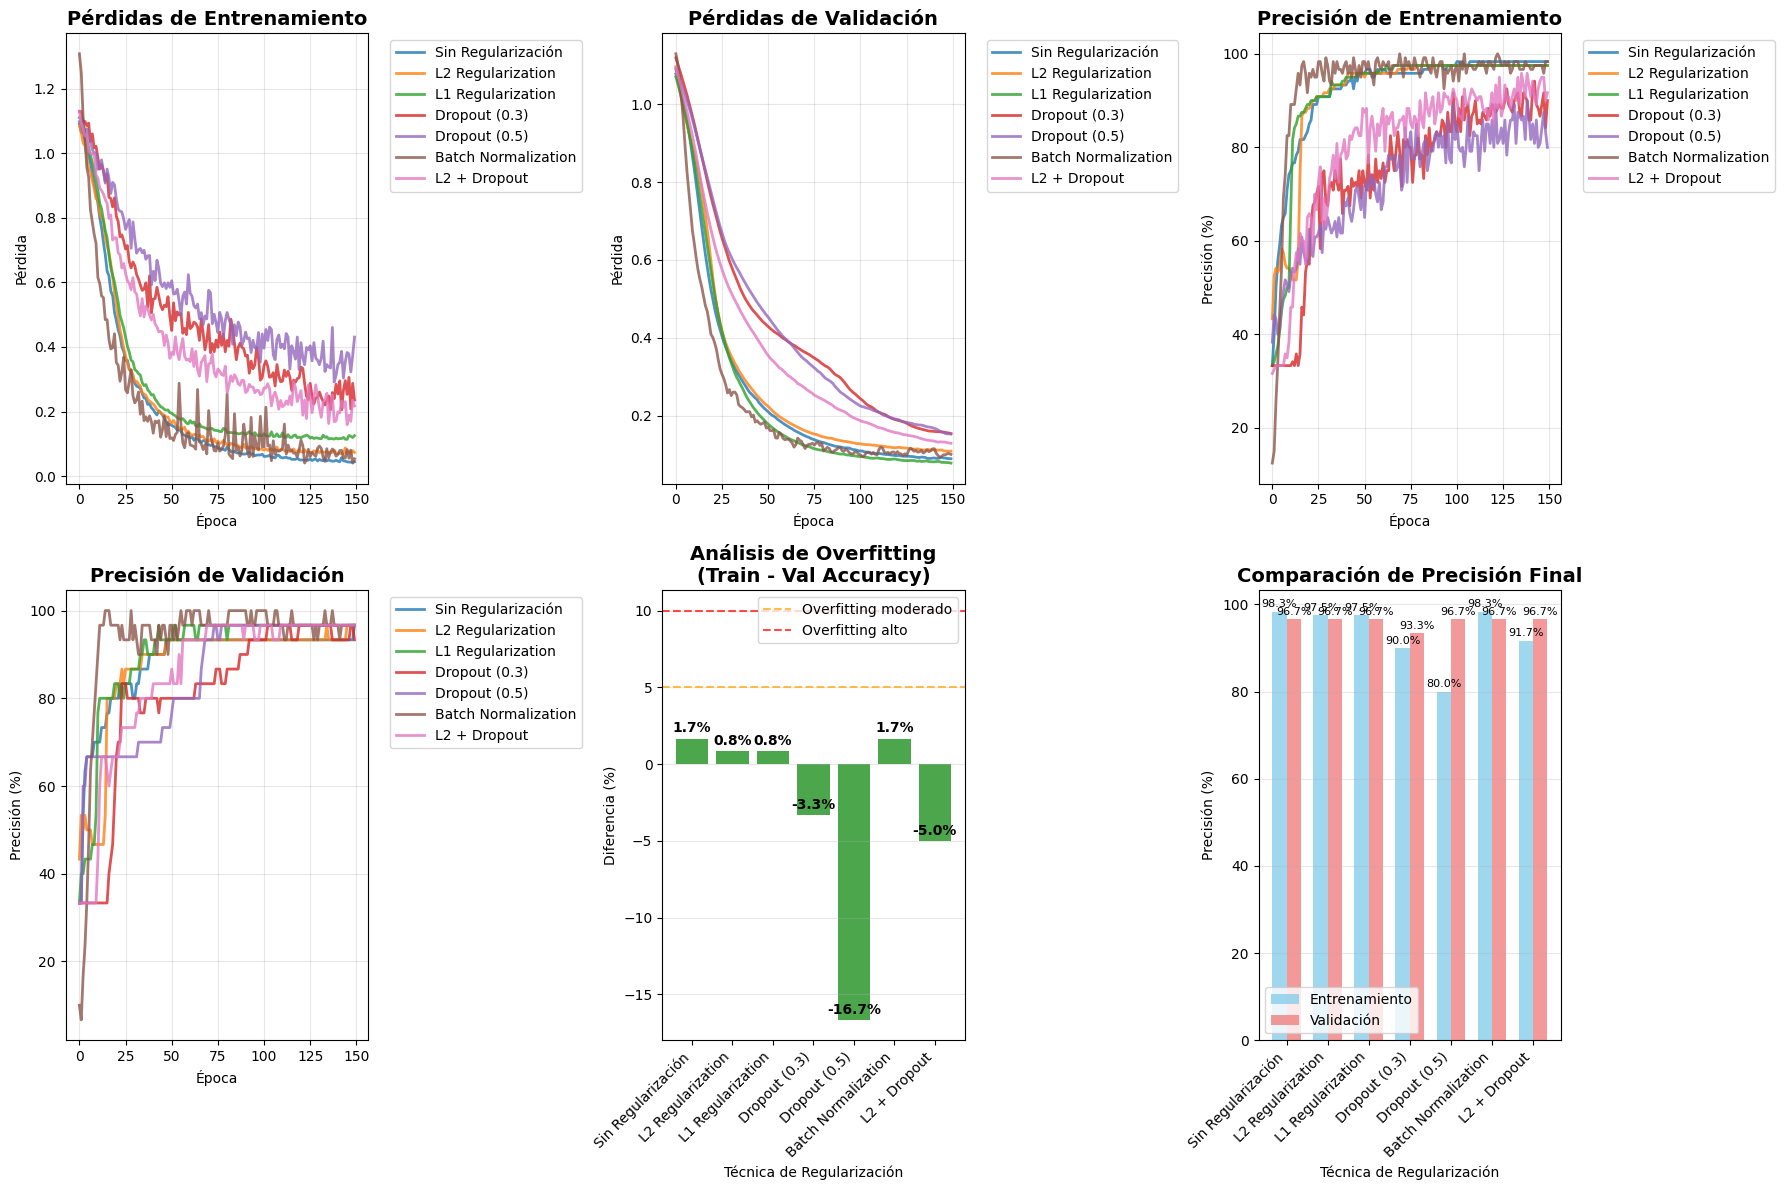


 TABLA COMPARATIVA COMPLETA:
----------------------------------------------------------------------------------------------------
Técnica              Train%   Val%     Overfitting  Convergencia Estabilidad
----------------------------------------------------------------------------------------------------
Sin Regularización    98.33%  96.67%    +1.67%       43 épocas   0.60%
L2 Regularization     97.50%  96.67%    +0.83%       41 épocas   1.33%
L1 Regularization     97.50%  96.67%    +0.83%       40 épocas   0.00%
Dropout (0.3)         90.00%  93.33%    -3.33%      150 épocas   1.61%
Dropout (0.5)         80.00%  96.67%   -16.67%      150 épocas   0.00%
Batch Normalization   98.33%  96.67%    +1.67%       14 épocas   1.36%
L2 + Dropout          91.67%  96.67%    -5.00%      123 épocas   0.00%
----------------------------------------------------------------------------------------------------


In [15]:
plt.figure(figsize=(18, 12))

# Subplot 1: Evolución de pérdidas de entrenamiento
plt.subplot(2, 3, 1)
for reg_name, result in regularization_results.items():
    plt.plot(result['train_losses'], label=reg_name, linewidth=2, alpha=0.8)
plt.title('Pérdidas de Entrenamiento', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subplot 2: Evolución de pérdidas de validación
plt.subplot(2, 3, 2)
for reg_name, result in regularization_results.items():
    plt.plot(result['val_losses'], label=reg_name, linewidth=2, alpha=0.8)
plt.title('Pérdidas de Validación', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subplot 3: Evolución de precisión de entrenamiento
plt.subplot(2, 3, 3)
for reg_name, result in regularization_results.items():
    plt.plot(result['train_accuracies'], label=reg_name, linewidth=2, alpha=0.8)
plt.title('Precisión de Entrenamiento', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subplot 4: Evolución de precisión de validación
plt.subplot(2, 3, 4)
for reg_name, result in regularization_results.items():
    plt.plot(result['val_accuracies'], label=reg_name, linewidth=2, alpha=0.8)
plt.title('Precisión de Validación', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subplot 5: Análisis de overfitting
plt.subplot(2, 3, 5)
reg_names = list(regularization_results.keys())
overfitting_scores = [regularization_results[name]['overfitting'] for name in reg_names]
colors = ['red' if score > 10 else 'orange' if score > 5 else 'green' for score in overfitting_scores]

bars = plt.bar(range(len(reg_names)), overfitting_scores, color=colors, alpha=0.7)
plt.title('Análisis de Overfitting\n(Train - Val Accuracy)', fontsize=14, fontweight='bold')
plt.xlabel('Técnica de Regularización')
plt.ylabel('Diferencia (%)')
plt.xticks(range(len(reg_names)), reg_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Agregar líneas de referencia
plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='Overfitting moderado')
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Overfitting alto')
plt.legend()

# Agregar valores en las barras
for bar, score in zip(bars, overfitting_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{score:.1f}%', ha='center', va='bottom', fontweight='bold')

# Subplot 6: Comparación de precisión final
plt.subplot(2, 3, 6)
train_accs_reg = [regularization_results[name]['final_train_acc'] for name in reg_names]
val_accs_reg = [regularization_results[name]['final_val_acc'] for name in reg_names]

x_pos = range(len(reg_names))
width = 0.35

bars1 = plt.bar([i - width/2 for i in x_pos], train_accs_reg, width, 
                label='Entrenamiento', alpha=0.8, color='skyblue')
bars2 = plt.bar([i + width/2 for i in x_pos], val_accs_reg, width, 
                label='Validación', alpha=0.8, color='lightcoral')

plt.title('Comparación de Precisión Final', fontsize=14, fontweight='bold')
plt.xlabel('Técnica de Regularización')
plt.ylabel('Precisión (%)')
plt.xticks(x_pos, reg_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

convergence_analysis = {}
for reg_name, result in regularization_results.items():
    epochs_to_95 = next((i for i, acc in enumerate(result['train_accuracies']) if acc >= 95), 
                        len(result['train_accuracies']))
    convergence_analysis[reg_name] = epochs_to_95


stability_analysis = {}
for reg_name, result in regularization_results.items():
    last_30_val_acc = result['val_accuracies'][-30:]
    stability = np.std(last_30_val_acc)
    stability_analysis[reg_name] = stability

# Crear tabla comparativa final
print(f"\n TABLA COMPARATIVA COMPLETA:")
print(f"-" * 100)
print(f"{'Técnica':<20} {'Train%':<8} {'Val%':<8} {'Overfitting':<12} {'Convergencia':<12} {'Estabilidad':<10}")
print(f"-" * 100)

for reg_name in reg_names:
    result = regularization_results[reg_name]
    conv_epochs = convergence_analysis[reg_name]
    stability = stability_analysis[reg_name]
    
    print(f"{reg_name:<20} {result['final_train_acc']:>6.2f}% {result['final_val_acc']:>6.2f}% "
          f"{result['overfitting']:>+8.2f}% {conv_epochs:>8d} épocas {stability:>6.2f}%")

print(f"-" * 100)